Loading stimuli for SALICON_train from ../data/pysaliency_datasets...
Loaded 10000 stimuli paths.
Inferred num_segments for colormap: 16


/tmp/ipykernel_2722533/3345114405.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_segments)


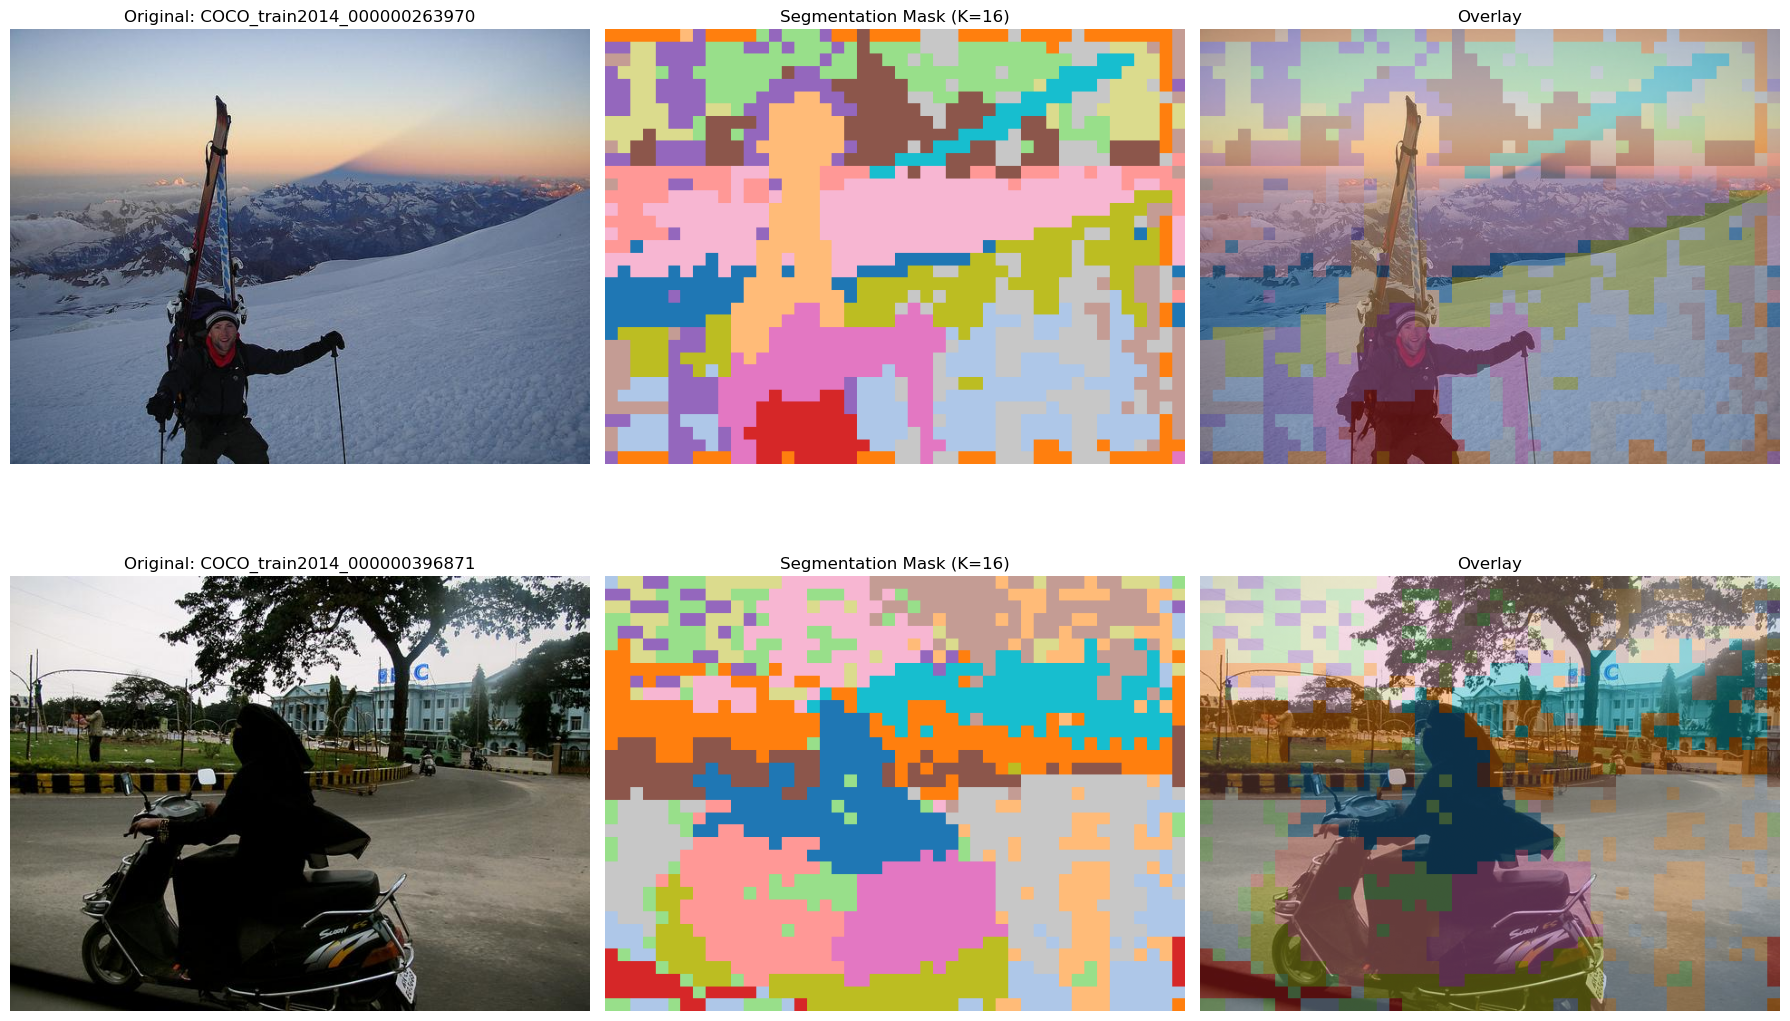

In [ ]:
# notebooks/visualize_segmentation_masks.ipynb

import os
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#import cv2 # OpenCV for blending, optional

# For pysaliency to load stimuli lists
import pysaliency
import torch # For loading .pkl if needed for stimuli lists

# Helper to add project root to sys.path if needed for custom modules (not strictly necessary for this notebook if stimuli are loaded directly)
# import sys
# PROJECT_ROOT = Path(os.path.abspath('')).resolve().parent # Assumes notebook is in notebooks/
# sys.path.append(str(PROJECT_ROOT))
# from src.utils import some_helper_if_needed # Example

# --- Configuration ---
# Adjust these paths according to your project structure and where masks are being saved
BASE_DATA_DIR = Path("../data/pysaliency_datasets")  # Path to where SALICON, MIT etc. are stored for pysaliency
# Example: masks for SALICON train, k=16
#MASK_DIR = Path("../masks/salicon/dinov2_kmeans_k16_salicon_train") # Path to the generated masks
MASK_DIR = Path("../masks/salicon/sam_vitb_k16_salicon_train") # Path to the generated masks
DATASET_NAME_FOR_STIMULI = "SALICON_train" # To load the correct stimuli list via pysaliency
STIMULI_LOCATION_FOR_PYSL = BASE_DATA_DIR # The location pysaliency needs

NUM_IMAGES_TO_SHOW = 2
MASK_FILE_FORMAT = "png" # "png" or "npy" (must match generate_masks.py setting)
ALPHA_OVERLAY = 0.4 # Transparency for mask overlay
max_k_for_colormap = 16 # Default, or parse from MASK_DIR (e.g., dinov2_kmeans_k16_...)

# fix random seed for reproducibility
random.seed(45)

# --- Helper Functions ---

def load_stimuli_list(dataset_name, stimuli_location):
    """Loads stimuli using pysaliency."""
    print(f"Loading stimuli for {dataset_name} from {stimuli_location}...")
    try:
        if dataset_name == 'SALICON_train':
            stimuli, _ = pysaliency.get_SALICON_train(location=stimuli_location)
        elif dataset_name == 'SALICON_val':
            stimuli, _ = pysaliency.get_SALICON_val(location=stimuli_location)
        elif dataset_name == 'MIT1003_twosize':
            mit_converted_stimuli_path = Path(stimuli_location) / "MIT1003_twosize" / "stimuli.pkl"
            if not mit_converted_stimuli_path.exists():
                 print(f"MIT1003_twosize stimuli.pkl not found at {mit_converted_stimuli_path}")
                 return None
            with open(mit_converted_stimuli_path, "rb") as f:
                 # Adjust loading based on how stimuli.pkl was saved (torch.load or pickle.load)
                 stimuli = torch.load(f) # Or pickle.load(f)
            if not isinstance(stimuli, pysaliency.FileStimuli):
                print("Error: Loaded MIT1003_twosize object is not a pysaliency.FileStimuli.")
                return None
        else:
            print(f"Unknown dataset_name: {dataset_name}")
            return None
        print(f"Loaded {len(stimuli)} stimuli paths.")
        return stimuli
    except Exception as e:
        print(f"Error loading stimuli: {e}")
        return None

def load_mask(mask_path_full, file_format="png"):
    """Loads a segmentation mask."""
    if not mask_path_full.exists():
        print(f"Mask file not found: {mask_path_full}")
        return None
    try:
        if file_format == "png":
            mask = Image.open(mask_path_full).convert('L') # Ensure grayscale for segment IDs
            return np.array(mask)
        elif file_format == "npy":
            return np.load(mask_path_full)
        else:
            print(f"Unsupported mask file format: {file_format}")
            return None
    except Exception as e:
        print(f"Error loading mask {mask_path_full}: {e}")
        return None

def generate_colormap(num_segments):
    """Generates a distinct colormap for a number of segments."""
    # Using matplotlib's 'tab20' and 'tab20b' for up to 40 distinct colors
    # For more, you might need a more sophisticated approach or accept similar colors
    if num_segments <= 20:
        colors = plt.cm.get_cmap('tab20', num_segments)
    elif num_segments <= 40: # Combine two colormaps
        colors1 = plt.cm.get_cmap('tab20', 20)
        colors2 = plt.cm.get_cmap('tab20b', num_segments - 20)
        combined_colors = [colors1(i) for i in range(20)] + [colors2(i) for i in range(num_segments-20)]
        return combined_colors
    else: # Fallback to a continuous map if too many segments, will have repeats
        print(f"Warning: More than 40 segments ({num_segments}), colormap will have repeating/similar colors.")
        colors = plt.cm.get_cmap('viridis', num_segments)
    
    # Return as a list of RGBA tuples (0-255 range for OpenCV)
    return [(int(r*255), int(g*255), int(b*255), 255) for r,g,b,a in [colors(i) for i in range(num_segments)]]


def apply_colormap_to_mask(mask_array, colormap):
    """Applies a colormap to a grayscale integer mask."""
    if mask_array is None:
        return None
    colored_mask = np.zeros((mask_array.shape[0], mask_array.shape[1], 3), dtype=np.uint8)
    unique_labels = np.unique(mask_array)

    for label_val in unique_labels:
        if label_val < len(colormap):
            color = colormap[label_val][:3] # Get RGB part
            colored_mask[mask_array == label_val] = color
        else: # Fallback if label > number of colors (should not happen if colormap generated correctly)
            colored_mask[mask_array == label_val] = (255, 255, 255) # White
    return colored_mask

# --- Main Visualization ---

# Load stimuli paths
stimuli_pysal = load_stimuli_list(DATASET_NAME_FOR_STIMULI, STIMULI_LOCATION_FOR_PYSL)

if stimuli_pysal:
    all_stimuli_filenames = stimuli_pysal.filenames
    if len(all_stimuli_filenames) == 0:
        print("No stimuli found. Please check dataset name and location.")
    else:
        # Randomly select some images to display
        if len(all_stimuli_filenames) > NUM_IMAGES_TO_SHOW:
            selected_indices = random.sample(range(len(all_stimuli_filenames)), NUM_IMAGES_TO_SHOW)
        else:
            selected_indices = list(range(len(all_stimuli_filenames)))

        # Estimate max number of segments from a few masks to generate colormap
        # This is a bit heuristic; ideally, you know num_segments from generation
        # Or, parse it from the MASK_DIR name if it's consistent
        if "kmeans_k" in MASK_DIR.name:
            try:
                max_k_for_colormap = int(MASK_DIR.name.split("kmeans_k")[1].split("_")[0])
                print(f"Inferred num_segments for colormap: {max_k_for_colormap}")
            except:
                print(f"Could not infer num_segments from MASK_DIR name, using default: {max_k_for_colormap}")

        colormap = generate_colormap(max_k_for_colormap + 1) # +1 in case segment IDs are 0 to K-1

        fig, axes = plt.subplots(len(selected_indices), 3, figsize=(18, 6 * len(selected_indices)))
        if len(selected_indices) == 1: # Matplotlib returns a single Axes object if only 1 row/col
            axes = np.array([axes]) # Make it 2D for consistent indexing

        for i, stim_idx in enumerate(selected_indices):
            img_path_abs = Path(all_stimuli_filenames[stim_idx])
            img_basename = img_path_abs.stem

            # Load original image
            try:
                original_img_pil = Image.open(img_path_abs).convert("RGB")
                original_img_np = np.array(original_img_pil)
            except Exception as e:
                print(f"Could not load image {img_path_abs}: {e}")
                if len(selected_indices) > 1 :
                    axes[i, 0].set_title(f"Error loading image: {img_basename}")
                    axes[i, 0].axis('off')
                    axes[i, 1].axis('off')
                    axes[i, 2].axis('off')
                else: # single image case
                    axes[0].set_title(f"Error loading image: {img_basename}")
                    axes[0].axis('off')
                    axes[1].axis('off')
                    axes[2].axis('off')
                continue

            # Construct mask path
            mask_filename = f"{img_basename}.{MASK_FILE_FORMAT}"
            mask_path_full = MASK_DIR / mask_filename

            # Load mask
            mask_array = load_mask(mask_path_full, MASK_FILE_FORMAT)

            # Plot original image
            ax_img = axes[i, 0]
            ax_img.imshow(original_img_np)
            ax_img.set_title(f"Original: {img_basename}")
            ax_img.axis('off')

            # Plot colored mask
            ax_mask = axes[i, 1]
            if mask_array is not None:
                colored_mask_np = apply_colormap_to_mask(mask_array, colormap)
                ax_mask.imshow(colored_mask_np)
                ax_mask.set_title(f"Segmentation Mask (K={np.max(mask_array)+1 if mask_array is not None else 'N/A'})")
            else:
                ax_mask.text(0.5, 0.5, "Mask not found\nor error loading", ha='center', va='center')
                ax_mask.set_title("Segmentation Mask")
            ax_mask.axis('off')

            # Plot overlay
            ax_overlay = axes[i, 2]
            if mask_array is not None and colored_mask_np is not None:
                # Ensure original_img_np is suitable for imshow (e.g., float 0-1 or uint8 0-255)
                if original_img_np.dtype != np.uint8:
                    if original_img_np.max() <= 1.0 and original_img_np.min() >= 0.0:
                        img_for_overlay = original_img_np # Already float 0-1
                    else: # Convert to float 0-1 if it's not uint8 and not in 0-1 range
                        img_min, img_max = original_img_np.min(), original_img_np.max()
                        if img_max > img_min: # Avoid division by zero
                            img_for_overlay = (original_img_np - img_min) / (img_max - img_min)
                        else:
                            img_for_overlay = np.zeros_like(original_img_np, dtype=float)
                else: # If uint8, convert to float 0-1 for consistent alpha blending
                    img_for_overlay = original_img_np.astype(float) / 255.0

                # Ensure colored_mask_np is also float 0-1
                if colored_mask_np.dtype != np.uint8:
                    mask_for_overlay = colored_mask_np # Assuming it might already be float
                    if mask_for_overlay.max() > 1.0: # Normalize if not in 0-1
                         mask_for_overlay = mask_for_overlay.astype(float) / 255.0
                else:
                    mask_for_overlay = colored_mask_np.astype(float) / 255.0
                
                # Resize mask to match image if necessary (should already be done by generate_masks)
                if img_for_overlay.shape[:2] != mask_for_overlay.shape[:2]:
                    print(f"Warning: Image shape {img_for_overlay.shape[:2]} and mask shape {mask_for_overlay.shape[:2]} differ for {img_basename}. Resizing mask for overlay.")
                    # Use PIL for resizing to maintain consistency with how masks might be generated/resized
                    mask_pil_temp = Image.fromarray((mask_for_overlay * 255).astype(np.uint8))
                    mask_pil_resized_temp = mask_pil_temp.resize((img_for_overlay.shape[1], img_for_overlay.shape[0]), Image.NEAREST)
                    mask_for_overlay = np.array(mask_pil_resized_temp).astype(float) / 255.0


                try:
                    # Plot the original image first
                    ax_overlay.imshow(img_for_overlay)
                    # Plot the colored mask on top with alpha blending
                    ax_overlay.imshow(mask_for_overlay, alpha=ALPHA_OVERLAY)
                    ax_overlay.set_title(f"Overlay")
                except Exception as e_overlay:
                    print(f"Error creating overlay for {img_basename}: {e_overlay}")
                    ax_overlay.text(0.5, 0.5, "Error in overlay", ha='center', va='center')

            else:
                ax_overlay.text(0.5, 0.5, "Mask not available\nfor overlay", ha='center', va='center')
                ax_overlay.set_title("Overlay")
            ax_overlay.axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Could not load stimuli list. Please check configuration.")